In [1]:
import ROOT as rt
import array as array
import os
import glob
from random import gauss
import numpy as np
import root_numpy as rtnpy
import pandas as pd
import h5py
from awkward import JaggedArray, Table
import matplotlib.pyplot as plt
import seaborn as sns

Welcome to JupyROOT 6.14/09


In [2]:
lumi=5750+2573+4242+4025+3104+7576+8632
print lumi
CrossSection=np.array([1973000000,117200,7760,642.1,185.9,32.05,9.365,0.8398,0.1124,0.006752,0.0001626])
EventNumber=np.array([3520.33,6875125,4150588,9344512.12,6571952,8456672.59,6680029,831433,692968,834414,11166471])
Scale=lumi*CrossSection/EventNumber
print Scale
MC_Compo=np.array(['QCD Flat','QCD Pt170to300','QCD Pt300to470','QCD Pt470to600','QCD Pt600to800','QCD Pt800to1000','QCD Pt1000to1400','QCD Pt1400to1800','QCD Pt1800to2400','QCD Pt2400to3200','QCD Pt3200toInf'])

35902
[2.01215926e+10 6.12020058e+02 6.71229040e+01 2.46697462e+00
 1.01555547e+00 1.36065230e-01 5.03324507e-02 3.62632943e-02
 5.82333499e-03 2.90515624e-04 5.22785149e-07]


In [3]:
fData=[]
path='/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_JetHTRun2016*.root'
files=glob.glob(path)
for f in files:
    fData.append(f)
print len(fData)
fMC=[
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt-15to7000_TuneCUETP8M1_FlatP6_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_170to300_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_300to470_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_470to600_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_600to800_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_800to1000_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1000to1400_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1400to1800_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1800to2400_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_2400to3200_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_3200toInf_TuneCUETP8M1_13TeV_pythia8.root'
    ]

print len(fMC)

7
11


# Functions to refill histograms to new bins

In [4]:
def Fill1D(h0,h,bins):
    N=h0.GetNbinsX()
    content=np.zeros((len(bins)-1),dtype=float)
    for i in range(len(bins)-1):
        content[i]=0
    for i in range(N):
        center=h0.GetBinCenter(i+1)
        index=np.digitize(np.array([center]),bins)
        if index[0] < len(bins):
            content[index[0]-1]+=h0.GetBinContent(i+1)
    for i in range(len(bins)-1):
        h.SetBinContent(i+1,content[i])

def Fill2D(h0,h,binx,biny):
    Nx=h0.GetNbinsX()
    Ny=h0.GetNbinsY()
    hx=h0.ProjectionX()
    hy=h0.ProjectionY()
    content=np.zeros((len(binx)-1,len(biny)-1),dtype=float)
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            content[i][j]=0
    for i in range(Nx):
        for j in range(Ny):
            centerx=hx.GetBinCenter(i+1)
            indexx=np.digitize(np.array([centerx]),binx)
            centery=hy.GetBinCenter(j+1)
            indexy=np.digitize(np.array([centery]),biny)
            if indexx[0] < len(binx) and indexy[0] < len(biny):
                content[indexx[0]-1][indexy[0]-1]+=h0.GetBinContent(i+1,j+1)
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            h.SetBinContent(i+1,j+1,content[i][j])

# Purity and stability calculation

In [5]:
def PurityStability(h0,bins):
    
    h=rt.TH2D("",";;",bins.shape[0]-1,(bins),bins.shape[0]-1,(bins))
    Fill2D(h0,h,bins,bins)
    hx=h.ProjectionX()
    hy=h.ProjectionY()
    N=hx.GetNbinsX()
    
    nreco_pergenbin=[]
    nreco_genanywhere=[]
    ngen_recoanywhere=[]
    for i in range(N):
        nreco_pergenbin.append(h.GetBinContent(i+1,i+1))
        nreco_genanywhere.append(hy.GetBinContent(i+1))
        ngen_recoanywhere.append(hx.GetBinContent(i+1))
    nreco_pergenbin=np.array(nreco_pergenbin)
    nreco_genanywhere=np.array(nreco_genanywhere)
    ngen_recoanywhere=np.array(ngen_recoanywhere)
    
    purity_arr=1.0*nreco_pergenbin/nreco_genanywhere
    stability_arr=1.0*nreco_pergenbin/ngen_recoanywhere
    
    purity=rt.TH1D("Purity",";;",bins.shape[0]-1,(bins))
    stability=rt.TH1D("Stability",";;",bins.shape[0]-1,(bins))
    
    for i in range(N):
        purity.SetBinContent(i+1,purity_arr[i])
        stability.SetBinContent(i+1,stability_arr[i])
    
    purity.SetLineWidth(2)
    purity.SetLineStyle(2)
    stability.SetLineWidth(2)
    stability.SetLineStyle(2)
    
    return purity,stability

# Do unfolding

In [6]:
def DoUnfolding(Response,Data_reco,MC_reco,MC_gen,HSname,MCname,gen_bins):
    
    tunfolderMC = rt.TUnfoldDensity(Response,rt.TUnfold.kHistMapOutputHoriz,rt.TUnfold.kRegModeCurvature, rt.TUnfold.kEConstraintNone, rt.TUnfoldDensity.kDensityModeBinWidth)
    tunfolderMC.SetInput(MC_reco)
    MC_unfolded=tunfolderMC.DoUnfold(0.)
    MC_unfolded=tunfolderMC.GetOutput("MC_unfolded")
    
    tunfolderData = rt.TUnfoldDensity(Response,rt.TUnfold.kHistMapOutputHoriz,rt.TUnfold.kRegModeCurvature, rt.TUnfold.kEConstraintNone, rt.TUnfoldDensity.kDensityModeBinWidth)
    tunfolderData.SetInput(Data_reco)
    Data_unfolded=tunfolderData.DoUnfold(0.)
    Data_unfolded=tunfolderData.GetOutput("Data_unfolded")
    
    MC_unfolded.SetMarkerStyle(2)
    MC_unfolded.SetMarkerColor(7)
    MC_unfolded.SetLineColor(7)
    MC_unfolded.SetLineWidth(1)
    
    Data_unfolded.SetMarkerStyle(22)
    Data_unfolded.SetMarkerColor(1)
    Data_unfolded.SetLineColor(1)
    Data_unfolded.SetLineWidth(2)
    
    MC_gen.SetMarkerStyle(5)
    MC_gen.SetMarkerColor(2)
    MC_gen.SetLineColor(2)
    
    ratio=rt.TH1D("Ratios "+HSname,"Ratios "+HSname+";"+HSname+";#frac{MC_unfolded}{MC_gen} ("+MCname+")",gen_bins.shape[0]-1,(gen_bins))
    ratio.Add(MC_unfolded)
    ratio.Divide(MC_gen)
    ratio.SetStats(0)
    ratio.SetMarkerStyle(5)
    ratio.SetMarkerColor(rt.kRed)
    ratio.SetLineColor(rt.kRed)
    ratio.GetYaxis().SetRangeUser(0.5,1.5)
    
    hs=rt.THStack(HSname,HSname)
    hs.Add(MC_unfolded,"E")
    hs.Add(MC_gen,"Hist")
    hs.Add(Data_unfolded,"E")
    
    leg=rt.TLegend(0.5, 0.5, 0.9, 0.8)
    #leg.SetTextSize(6)
    leg.AddEntry(Data_unfolded,"Data_unfolded",'p')
    leg.AddEntry(MC_unfolded,"MC_unfolded ("+MCname+")", 'p')
    leg.AddEntry(MC_gen,"MC_gen ("+MCname+")", 'f')
    leg.SetLineColor(0)
    leg.SetBorderSize(0)
    leg.SetFillStyle(0)
    
    return hs,ratio,leg

# $\tau_2^{(0.5)}$

In [7]:
reco='recoJet_tau_0p5_2_WTA_kT_nom_dijetSel'
gen='genJet_tau_0p5_2_WTA_kT_dijetSel'
response='respJet_tau_0p5_2_WTA_kT_nom_dijetSel'

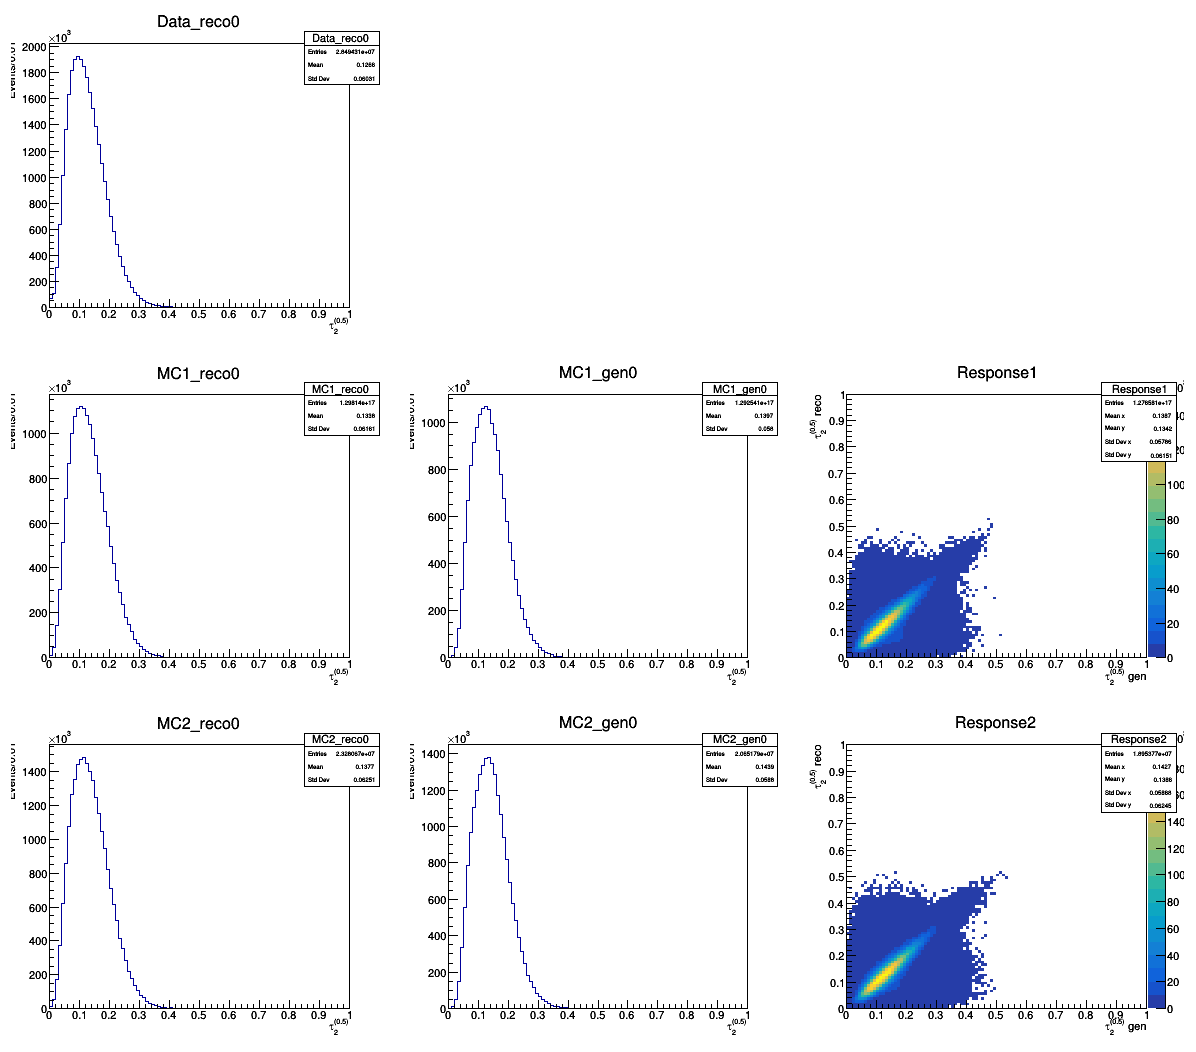

In [8]:
Data_reco0=rt.TH1D("Data_reco0","Data_reco0;#tau_{2}^{(0.5)};Events/0.01",100,0,1)
MC1_reco0=rt.TH1D("MC1_reco0","MC1_reco0;#tau_{2}^{(0.5)};Events/0.01",100,0,1)
MC1_gen0=rt.TH1D("MC1_gen0","MC1_gen0;#tau_{2}^{(0.5)};Events/0.01",100,0,1)
MC2_reco0=rt.TH1D("MC2_reco0","MC2_reco0;#tau_{2}^{(0.5)};Events/0.01",100,0,1)
MC2_gen0=rt.TH1D("MC2_gen0","MC2_gen0;#tau_{2}^{(0.5)};Events/0.01",100,0,1)
Response1_0=rt.TH2D("Response1","Response1;#tau_{2}^{(0.5)} gen;#tau_{2}^{(0.5)} reco",100,0,1,100,0,1)
Response2_0=rt.TH2D("Response2","Response2;#tau_{2}^{(0.5)} gen;#tau_{2}^{(0.5)} reco",100,0,1,100,0,1)

f_Data=np.zeros((len(fData),),dtype=rt.TFile)
for i in range(len(fData)):
    f_Data[i]=rt.TFile.Open(fData[i],'read')
    t=f_Data[i].Get('jetObservables')
    hist=rt.TH1D("",";;",20,0,1)
    Data_reco0.Add(t.Get(reco))
    f_Data[i].Close()

f_MC=np.zeros((len(fMC),),dtype=rt.TFile)
i=0
f_MC[i]=rt.TFile.Open(fMC[i],'read')
t=f_MC[i].Get('jetObservables')
MC1_reco0.Add(t.Get(reco),Scale[i])
MC1_gen0.Add(t.Get(gen),Scale[i])
Response1_0.Add(t.Get(response),Scale[i])
f_MC[i].Close()

for i in range(1,len(fMC)):
    f_MC[i]=rt.TFile.Open(fMC[i],'read')
    t=f_MC[i].Get('jetObservables')
    MC2_reco0.Add(t.Get(reco),Scale[i])
    MC2_gen0.Add(t.Get(gen),Scale[i])
    Response2_0.Add(t.Get(response),Scale[i])
    f_MC[i].Close()

c0=rt.TCanvas("c0","c0",0,0,1200,1080)
c0.Divide(3,3)
c0.cd(1)
Data_reco0.Draw("hist")
c0.cd(4)
MC1_reco0.Draw("hist")
c0.cd(5)
MC1_gen0.Draw("hist")
c0.cd(6)
Response1_0.Draw("Colz")
c0.cd(7)
MC2_reco0.Draw("hist")
c0.cd(8)
MC2_gen0.Draw("hist")
c0.cd(9)
Response2_0.Draw("Colz")
c0.Draw()

# Different bins

In [9]:
for i in range(MC2_reco0.GetNbinsX()):
    print Response2_0.ProjectionX().GetBinCenter(i+1),Response2_0.ProjectionX().GetBinContent(i+1),Response2_0.ProjectionY().GetBinContent(i+1)

0.005 2869.22375671 10452.5817848
0.015 11256.915464 42798.2322836
0.025 46877.0256137 134524.676245
0.035 143343.601373 290872.100038
0.045 320164.829154 490929.174409
0.055 533753.896189 683977.742365
0.065 748764.689583 850927.000505
0.075 922492.185193 1002284.73727
0.085 1046422.04783 1083843.91305
0.095 1136297.43085 1165507.82989
0.105 1200302.61483 1187983.99042
0.115 1245037.06271 1199695.2448
0.125 1271218.19467 1184992.30026
0.135 1268444.66772 1152437.8589
0.145 1232576.43615 1103279.86255
0.155 1175476.07853 1020661.71522
0.165 1065957.82587 954052.918557
0.175 961225.59827 863384.710971
0.185 852827.101017 776108.796102
0.195 736055.599622 686093.32585
0.205 627786.99975 590041.835069
0.215 515113.875129 504167.64738
0.225 434817.066209 428018.007937
0.235 343910.225647 343340.613001
0.245 284956.415265 291560.468584
0.255 223493.775142 232544.386217
0.265 163807.804087 178670.887817
0.275 133643.688225 142845.290509
0.285 102540.585136 111322.020145
0.295 73475.4636799 8

In [10]:
gen_bins=[]
reco_bins=[]

gen_bins1=np.array([x for x in np.linspace(num=5,start=0.,stop=0.4)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.54])))
reco_bins1=np.array([x for x in np.linspace(num=9,start=0.,stop=0.4)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.45,0.54])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=6,start=0.,stop=0.4)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.54])))
reco_bins1=np.array([x for x in np.linspace(num=11,start=0.,stop=0.4)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.45,0.54])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=7,start=0.,stop=0.36)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.54])))
reco_bins1=np.array([x for x in np.linspace(num=13,start=0.,stop=0.36)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.42,0.54])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=11,start=0.,stop=0.4)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.54])))
reco_bins1=np.array([x for x in np.linspace(num=21,start=0,stop=0.4)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.45,0.54])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=21,start=0.,stop=0.4)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.54])))
reco_bins1=np.array([x for x in np.linspace(num=41,start=0.,stop=0.4)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.45,0.54])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

Colors=[rt.kRed,rt.kPink+9,rt.kYellow-7,rt.kSpring-9,rt.kAzure+8,rt.kBlue]

[0.   0.1  0.2  0.3  0.4  0.54] 5
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.54] 10
[0.   0.08 0.16 0.24 0.32 0.4  0.54] 6
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.45 0.54] 12
[0.   0.06 0.12 0.18 0.24 0.3  0.36 0.54] 7
[0.   0.03 0.06 0.09 0.12 0.15 0.18 0.21 0.24 0.27 0.3  0.33 0.36 0.42
 0.54] 14
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.54] 11
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.45 0.54] 22
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.54] 21
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.45
 0.54] 42


In [11]:
hist_purities=[]
hist_stabilities=[]
stack_unfoldings=[]
ratio_unfoldings=[]

responses=[]

c=rt.TCanvas()
stack_purities=rt.THStack("purities","purities")
stack_stabilities=rt.THStack("stabilities","stabilities")

leg_unfoldings=[]
leg_purities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_purities.SetLineColor(0)
leg_purities.SetBorderSize(0)
leg_purities.SetFillStyle(0)
leg_stabilities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_stabilities.SetLineColor(0)
leg_stabilities.SetBorderSize(0)
leg_stabilities.SetFillStyle(0)

for i in range(len(gen_bins)):
    gen_bin=gen_bins[i]
    reco_bin=reco_bins[i]
    print "for binning %d"%(i+1)
    print gen_bin
    
    Data_reco=rt.TH1D("Data_reco","Data_reco;#tau_{2}^{(0.5)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_reco=rt.TH1D("MC_reco (QCD)","MC2_reco (QCD);#tau_{2}^{(0.5)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_gen=rt.TH1D("MC_gen (QCD)","MC_gen (QCD);#tau_{2}^{(0.5)};Events",gen_bin.shape[0]-1,gen_bin)
    Response2=rt.TH2D("Response Matrix (QCD)","Response Matrix (QCD);#tau_{2}^{(0.5)} gen;#tau_{2}^{(0.5)} reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
    
    Fill1D(Data_reco0,Data_reco,reco_bin)
    Fill1D(MC2_reco0,MC2_reco,reco_bin)
    Fill1D(MC2_gen0,MC2_gen,gen_bin)
    Fill2D(Response2_0,Response2,gen_bin,reco_bin)

    Response2.SetTitle("Response Matrix #tau_{2}^{(0.5)} binning %d"%(i+1))
    Response2.SetStats(0)
    responses.append(Response2)
    
    purity,stability=PurityStability(Response2_0,gen_bin)
    
    purity.SetTitle("purity %d"%(i+1))
    stability.SetTitle("stability %d"%(i+1))
    purity.SetLineColor(Colors[i])
    stability.SetLineColor(Colors[i])
    hist_purities.append(purity)
    hist_stabilities.append(stability)
    stack_purities.Add(purity)
    stack_stabilities.Add(stability)
    leg_purities.AddEntry(purity,"binning %d"%(i+1))
    leg_stabilities.AddEntry(stability,"binning %d"%(i+1))
    
    Data_reco.Scale(1.0/Data_reco.Integral())
    MC2_reco.Scale(1.0/MC2_reco.Integral())
    MC2_gen.Scale(1.0/MC2_gen.Integral())
    
    hs,ratio,leg=DoUnfolding(Response2,Data_reco,MC2_reco,MC2_gen,"#tau_{2}^{(0.5)}","QCD",gen_bin)
    
    hs.SetTitle("#tau_{2}^{(0.5)} binning %d"%(i+1))
    ratio.SetTitle("Ratios binning %d"%(i+1))
    stack_unfoldings.append(hs)
    ratio_unfoldings.append(ratio)
    leg_unfoldings.append(leg)

for binning 1
[0.   0.1  0.2  0.3  0.4  0.54]
for binning 2
[0.   0.08 0.16 0.24 0.32 0.4  0.54]
for binning 3
[0.   0.06 0.12 0.18 0.24 0.3  0.36 0.54]
for binning 4
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.54]
for binning 5
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.54]


Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 10 input bins and 5 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{2}^{(0.5)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #6 (xaxis:#tau_{2}^{(0.5)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densityMode=1 axisSteering=*[UOB]
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 10 input bins and 5 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{2}^{(0.5)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #6 (xaxis:#tau_{2}^{(0.5)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densityMode=1 axisSteering=*[UOB]
Warning in

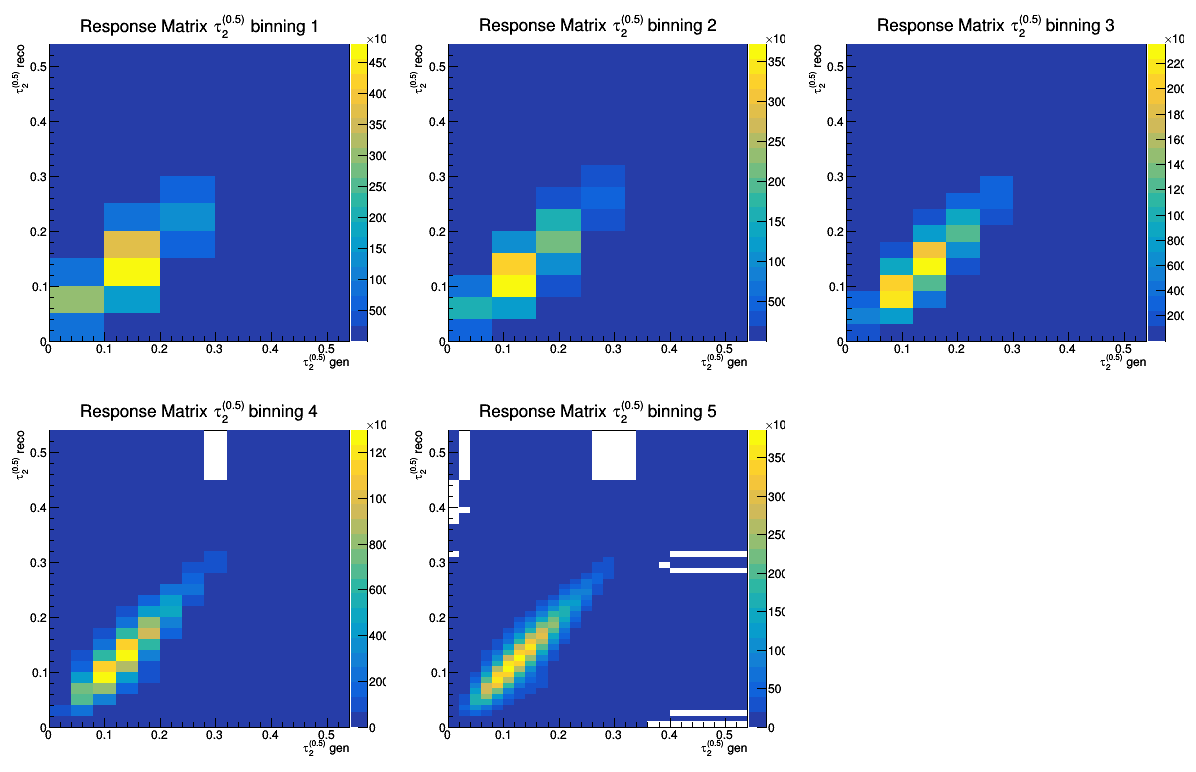

In [12]:
c=rt.TCanvas("","",0,0,1200,800)
c.Divide(3,2)
for i in range(len(gen_bins)):
    c.cd(i+1)
    responses[i].Draw("Colz")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


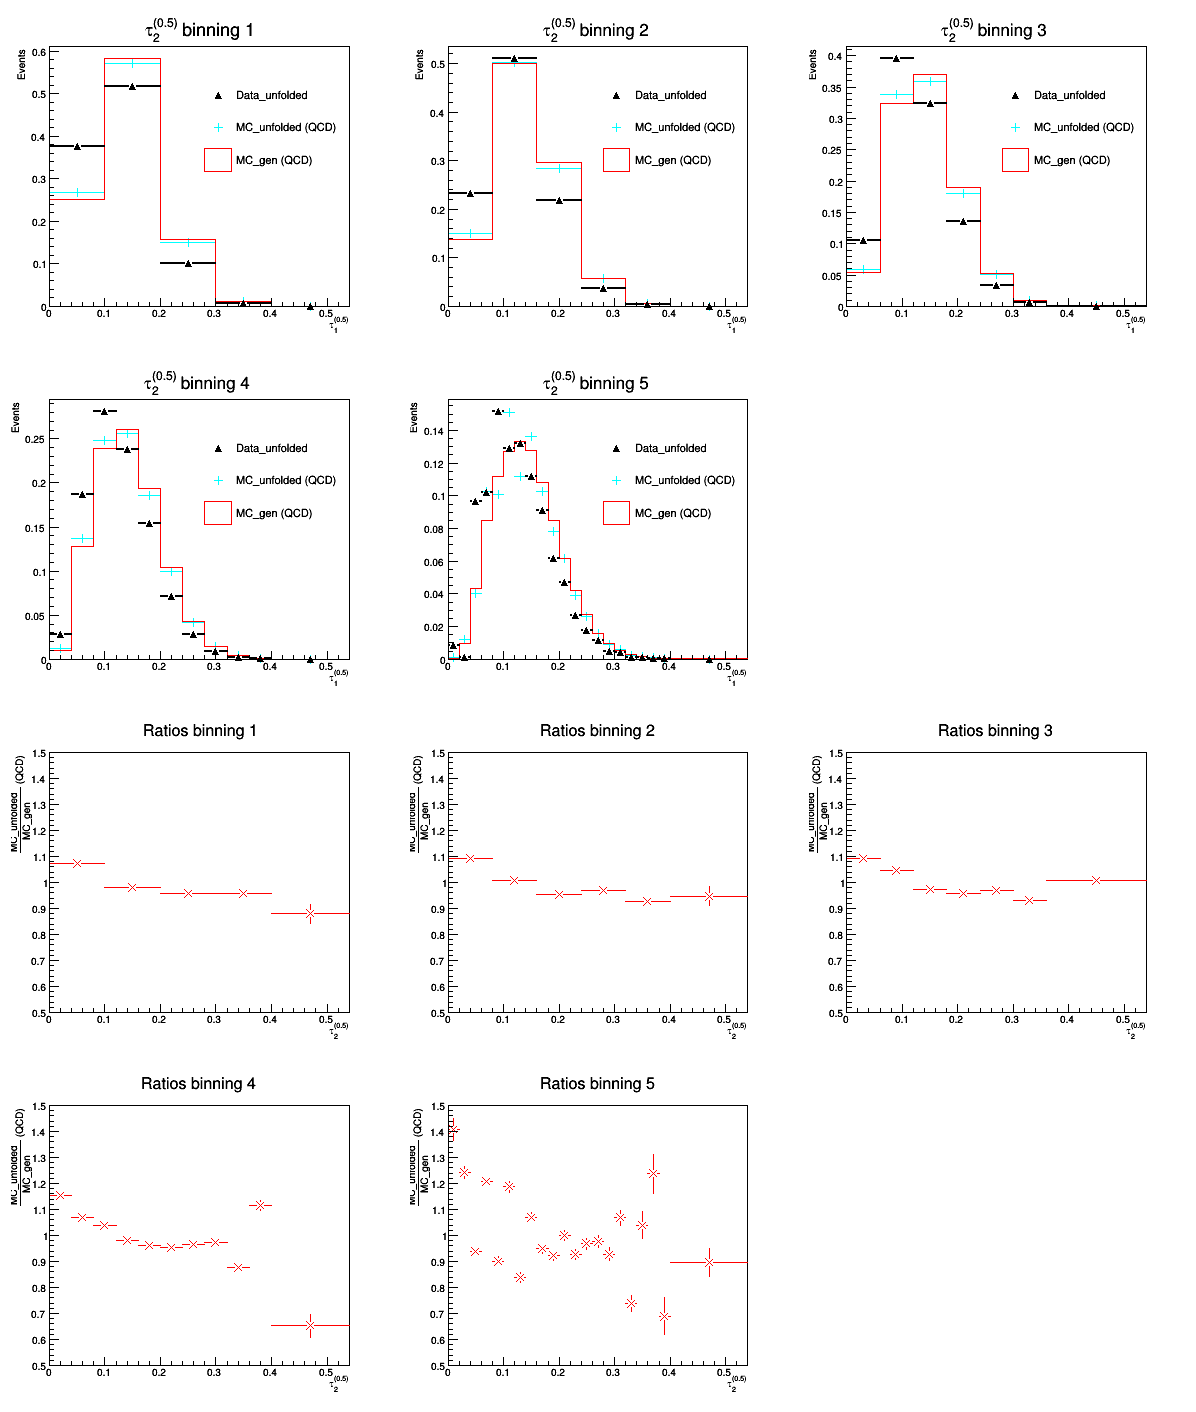

In [13]:
c=rt.TCanvas("","",0,0,1200,1440)
c.Divide(3,4)
for i in range(len(gen_bins)):
    c.cd(i+1)
    stack_unfoldings[i].Draw("nostack")
    stack_unfoldings[i].GetXaxis().SetTitle("#tau_{2}^{(0.5)}")
    stack_unfoldings[i].GetYaxis().SetTitle("Events")
    leg_unfoldings[i].Draw("Same")
for i in range(6,6+len(gen_bins)):
    c.cd(i+1)
    ratio_unfoldings[i-6].Draw()
c.Draw()

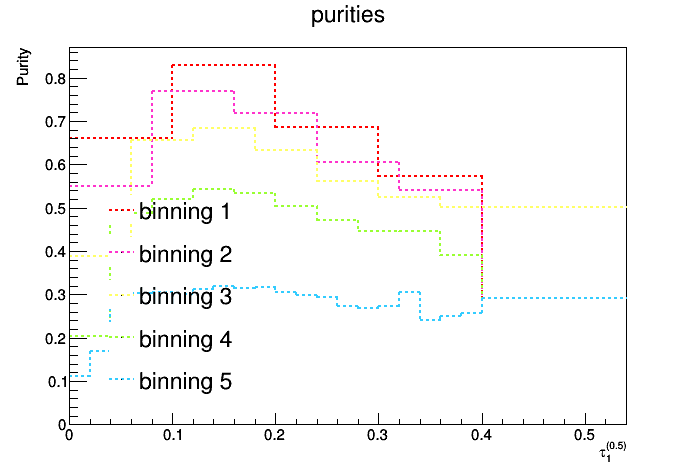

In [14]:
c=rt.TCanvas()
stack_purities.Draw("nostack")
stack_purities.GetXaxis().SetTitle("#tau_{2}^{(0.5)}")
stack_purities.GetYaxis().SetTitle("Purity")
stack_purities.Draw("nostack")
leg_purities.Draw("same")
c.Draw()

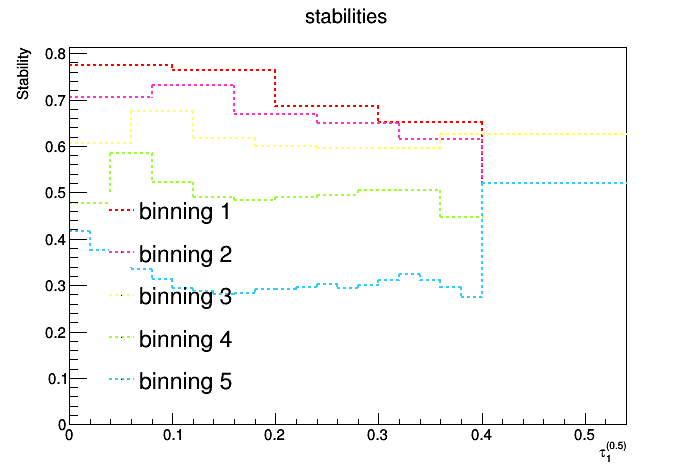

In [16]:
c=rt.TCanvas()
stack_stabilities.Draw("nostack")
stack_stabilities.GetXaxis().SetTitle("#tau_{2}^{(0.5)}")
stack_stabilities.GetYaxis().SetTitle("Stability")
stack_stabilities.Draw("nostack")
leg_stabilities.Draw("Same")
c.Draw()

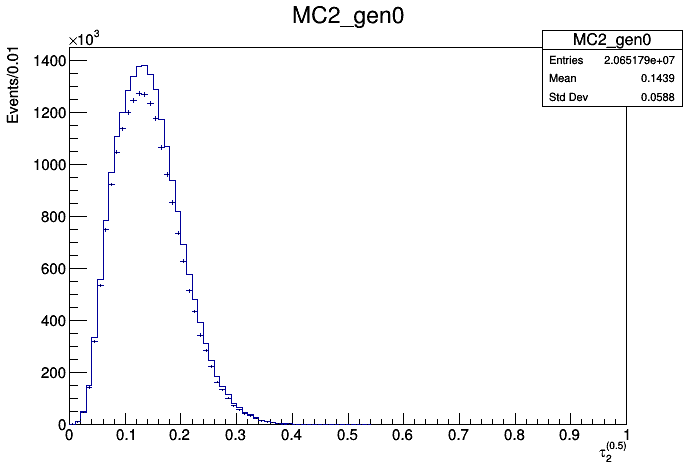

In [19]:
c=rt.TCanvas()
MC2_gen0.Draw("hist")
Response2_0.ProjectionX().Draw("Samee0")
c.Draw()

# $\tau_{2}^{(1)}$

In [20]:
reco='recoJet_tau_1_2_WTA_kT_nom_dijetSel'
gen='genJet_tau_1_2_WTA_kT_dijetSel'
response='respJet_tau_1_2_WTA_kT_nom_dijetSel'

Warning in <TROOT::Append>: Replacing existing TH1: Data_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC1_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC1_gen0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC2_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC2_gen0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response2 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c0


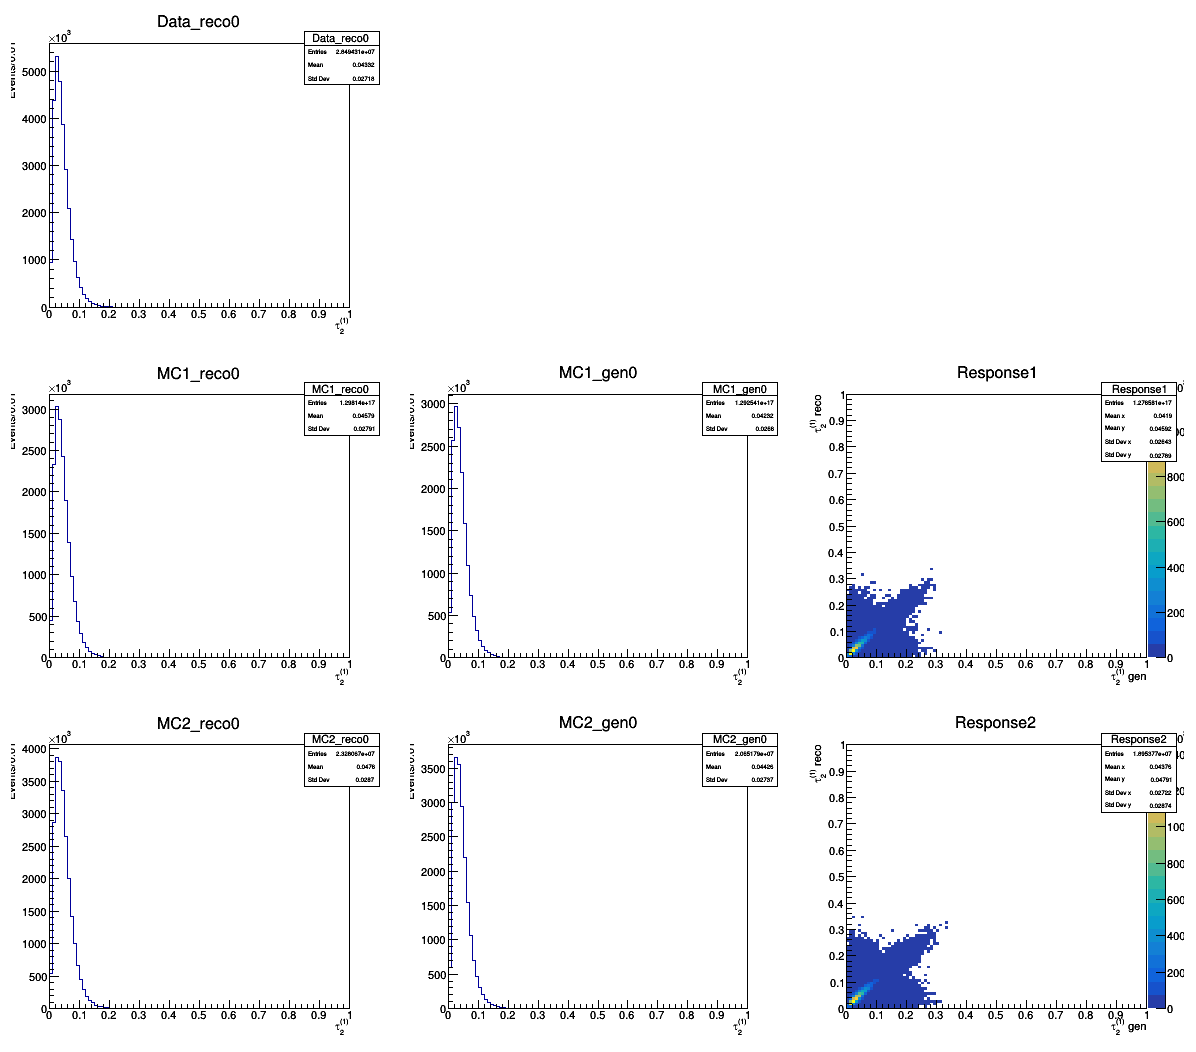

In [21]:
Data_reco0=rt.TH1D("Data_reco0","Data_reco0;#tau_{2}^{(1)};Events/0.01",100,0,1)
MC1_reco0=rt.TH1D("MC1_reco0","MC1_reco0;#tau_{2}^{(1)};Events/0.01",100,0,1)
MC1_gen0=rt.TH1D("MC1_gen0","MC1_gen0;#tau_{2}^{(1)};Events/0.01",100,0,1)
MC2_reco0=rt.TH1D("MC2_reco0","MC2_reco0;#tau_{2}^{(1)};Events/0.01",100,0,1)
MC2_gen0=rt.TH1D("MC2_gen0","MC2_gen0;#tau_{2}^{(1)};Events/0.01",100,0,1)
Response1_0=rt.TH2D("Response1","Response1;#tau_{2}^{(1)} gen;#tau_{2}^{(1)} reco",100,0,1,100,0,1)
Response2_0=rt.TH2D("Response2","Response2;#tau_{2}^{(1)} gen;#tau_{2}^{(1)} reco",100,0,1,100,0,1)

f_Data=np.zeros((len(fData),),dtype=rt.TFile)
for i in range(len(fData)):
    f_Data[i]=rt.TFile.Open(fData[i],'read')
    t=f_Data[i].Get('jetObservables')
    hist=rt.TH1D("",";;",20,0,1)
    Data_reco0.Add(t.Get(reco))
    f_Data[i].Close()

f_MC=np.zeros((len(fMC),),dtype=rt.TFile)
i=0
f_MC[i]=rt.TFile.Open(fMC[i],'read')
t=f_MC[i].Get('jetObservables')
MC1_reco0.Add(t.Get(reco),Scale[i])
MC1_gen0.Add(t.Get(gen),Scale[i])
Response1_0.Add(t.Get(response),Scale[i])
f_MC[i].Close()

for i in range(1,len(fMC)):
    f_MC[i]=rt.TFile.Open(fMC[i],'read')
    t=f_MC[i].Get('jetObservables')
    MC2_reco0.Add(t.Get(reco),Scale[i])
    MC2_gen0.Add(t.Get(gen),Scale[i])
    Response2_0.Add(t.Get(response),Scale[i])
    f_MC[i].Close()

c0=rt.TCanvas("c0","c0",0,0,1200,1080)
c0.Divide(3,3)
c0.cd(1)
Data_reco0.Draw("hist")
c0.cd(4)
MC1_reco0.Draw("hist")
c0.cd(5)
MC1_gen0.Draw("hist")
c0.cd(6)
Response1_0.Draw("Colz")
c0.cd(7)
MC2_reco0.Draw("hist")
c0.cd(8)
MC2_gen0.Draw("hist")
c0.cd(9)
Response2_0.Draw("Colz")
c0.Draw()

In [22]:
for i in range(MC2_reco0.GetNbinsX()):
    print Response2_0.ProjectionX().GetBinCenter(i+1),Response2_0.ProjectionX().GetBinContent(i+1),Response2_0.ProjectionY().GetBinContent(i+1)

0.005 573794.700243 434920.026781
0.015 2856851.65118 2261652.76535
0.025 3429375.06459 3108098.43089
0.035 3277400.06394 3083726.9366
0.045 2693081.27378 2732242.62932
0.055 1998197.49005 2165100.79291
0.065 1391906.11848 1653358.68283
0.075 960567.823975 1168411.37372
0.085 625626.479145 821679.915013
0.095 425567.039573 550043.615798
0.105 279068.862792 364504.307823
0.115 177378.428534 236833.773508
0.125 118335.942199 153626.68079
0.135 77616.4072166 104839.388046
0.145 52377.9495431 70747.9042577
0.155 37390.0545896 44156.8286383
0.165 23711.7865129 29813.7442158
0.175 13356.8425033 20804.4270419
0.185 9252.18448673 10751.5549674
0.195 6393.38934664 8074.59120467
0.205 4174.54268528 4752.33985835
0.215 2719.40672069 2616.60232118
0.225 878.261390938 3410.12918204
0.235 780.699919089 1170.70929267
0.245 422.044336995 543.698774065
0.255 63.8639059461 327.717201292
0.265 35.2364349628 185.629379054
0.275 309.721242551 225.569198837
0.285 18.4197074031 84.5432961155
0.295 76.6813368

In [23]:
gen_bins=[]
reco_bins=[]

gen_bins1=np.array([x for x in np.linspace(num=3,start=0.,stop=0.2)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.35])))
reco_bins1=np.array([x for x in np.linspace(num=5,start=0.,stop=0.2)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.26,0.35])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=4,start=0.,stop=0.24)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.35])))
reco_bins1=np.array([x for x in np.linspace(num=7,start=0.,stop=0.24)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.29,0.35])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=5,start=0.,stop=0.24)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.35])))
reco_bins1=np.array([x for x in np.linspace(num=9,start=0.,stop=0.24)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.29,0.35])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=7,start=0.,stop=0.24)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.35])))
reco_bins1=np.array([x for x in np.linspace(num=13,start=0.,stop=0.24)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.29,0.35])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=13,start=0.,stop=0.24)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.35])))
reco_bins1=np.array([x for x in np.linspace(num=25,start=0.,stop=0.24)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.29,0.35])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

Colors=[rt.kRed,rt.kPink+9,rt.kYellow-7,rt.kSpring-9,rt.kAzure+8,rt.kBlue]

[0.   0.1  0.2  0.35] 3
[0.   0.05 0.1  0.15 0.2  0.26 0.35] 6
[0.   0.08 0.16 0.24 0.35] 4
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.29 0.35] 8
[0.   0.06 0.12 0.18 0.24 0.35] 5
[0.   0.03 0.06 0.09 0.12 0.15 0.18 0.21 0.24 0.29 0.35] 10
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.35] 7
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.29
 0.35] 14
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.35] 13
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.29 0.35] 26


In [24]:
hist_purities=[]
hist_stabilities=[]
stack_unfoldings=[]
ratio_unfoldings=[]

responses=[]

c=rt.TCanvas()
stack_purities=rt.THStack("purities","purities")
stack_stabilities=rt.THStack("stabilities","stabilities")

leg_unfoldings=[]
leg_purities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_purities.SetLineColor(0)
leg_purities.SetBorderSize(0)
leg_purities.SetFillStyle(0)
leg_stabilities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_stabilities.SetLineColor(0)
leg_stabilities.SetBorderSize(0)
leg_stabilities.SetFillStyle(0)

for i in range(len(gen_bins)):
    gen_bin=gen_bins[i]
    reco_bin=reco_bins[i]
    print "for binning %d"%(i+1)
    print gen_bin
    
    Data_reco=rt.TH1D("Data_reco","Data_reco;#tau_{2}^{(1)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_reco=rt.TH1D("MC_reco (QCD)","MC2_reco (QCD);#tau_{2}^{(1)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_gen=rt.TH1D("MC_gen (QCD)","MC_gen (QCD);#tau_{2}^{(1)};Events",gen_bin.shape[0]-1,gen_bin)
    Response2=rt.TH2D("Response Matrix (QCD)","Response Matrix (QCD);#tau_{2}^{(1)} gen;#tau_{2}^{(1)} reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
    
    Fill1D(Data_reco0,Data_reco,reco_bin)
    Fill1D(MC2_reco0,MC2_reco,reco_bin)
    Fill1D(MC2_gen0,MC2_gen,gen_bin)
    Fill2D(Response2_0,Response2,gen_bin,reco_bin)

    Response2.SetTitle("Response Matrix #tau_{2}^{(1)} binning %d"%(i+1))
    Response2.SetStats(0)
    responses.append(Response2)
    
    purity,stability=PurityStability(Response2_0,gen_bin)
    
    purity.SetTitle("purity %d"%(i+1))
    stability.SetTitle("stability %d"%(i+1))
    purity.SetLineColor(Colors[i])
    stability.SetLineColor(Colors[i])
    hist_purities.append(purity)
    hist_stabilities.append(stability)
    stack_purities.Add(purity)
    stack_stabilities.Add(stability)
    leg_purities.AddEntry(purity,"binning %d"%(i+1))
    leg_stabilities.AddEntry(stability,"binning %d"%(i+1))
    
    Data_reco.Scale(1.0/Data_reco.Integral())
    MC2_reco.Scale(1.0/MC2_reco.Integral())
    MC2_gen.Scale(1.0/MC2_gen.Integral())
    
    hs,ratio,leg=DoUnfolding(Response2,Data_reco,MC2_reco,MC2_gen,"#tau_{2}^{(1)}","QCD",gen_bin)
    
    hs.SetTitle("#tau_{2}^{(1)} binning %d"%(i+1))
    ratio.SetTitle("Ratios binning %d"%(i+1))
    stack_unfoldings.append(hs)
    ratio_unfoldings.append(ratio)
    leg_unfoldings.append(leg)

for binning 1
[0.   0.1  0.2  0.35]
for binning 2
[0.   0.08 0.16 0.24 0.35]
for binning 3
[0.   0.06 0.12 0.18 0.24 0.35]
for binning 4
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.35]
for binning 5
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.35]


Warning in <TROOT::Append>: Replacing existing TH1: Data_reco (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_reco (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_gen (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response Matrix (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Purity (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Stability (Potential memory leak).
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 6 input bins and 3 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{2}^{(1)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #4 (xaxis:#tau_{2}^{(1)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densit

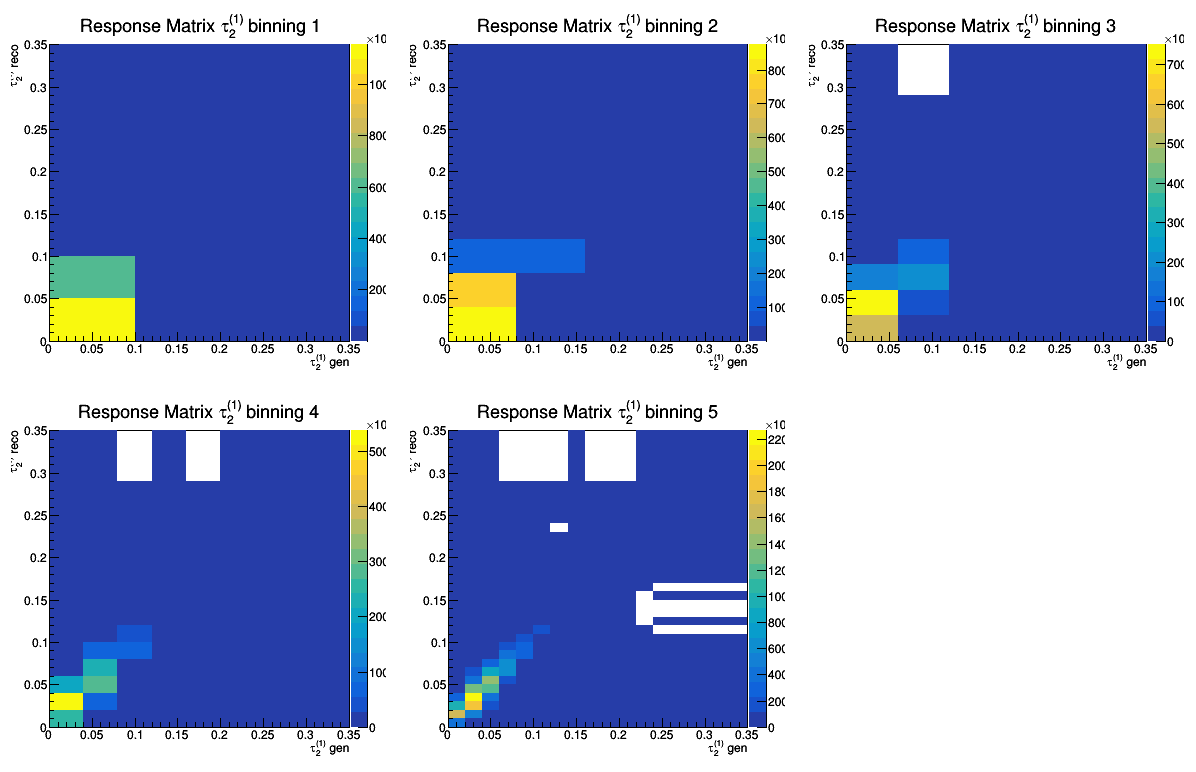

In [25]:
c=rt.TCanvas("","",0,0,1200,800)
c.Divide(3,2)
for i in range(len(gen_bins)):
    c.cd(i+1)
    responses[i].Draw("Colz")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


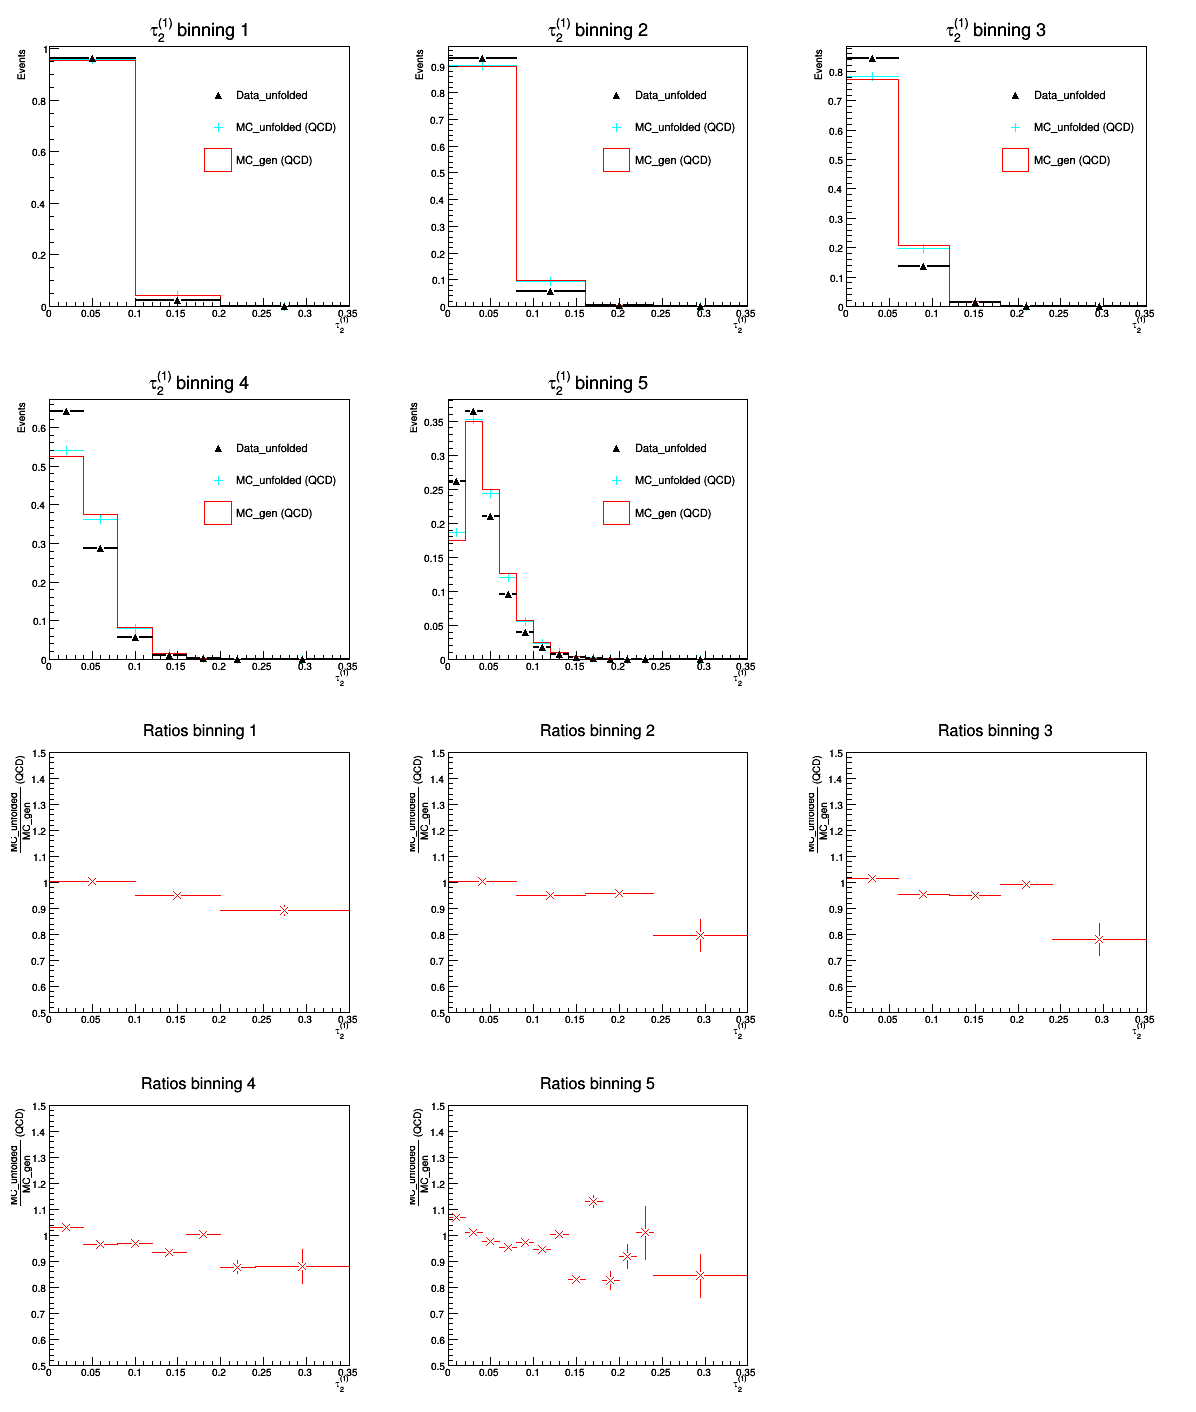

In [26]:
c=rt.TCanvas("","",0,0,1200,1440)
c.Divide(3,4)
for i in range(len(gen_bins)):
    c.cd(i+1)
    stack_unfoldings[i].Draw("nostack")
    stack_unfoldings[i].GetXaxis().SetTitle("#tau_{2}^{(1)}")
    stack_unfoldings[i].GetYaxis().SetTitle("Events")
    leg_unfoldings[i].Draw("Same")
for i in range(6,len(gen_bins)+6):
    c.cd(i+1)
    ratio_unfoldings[i-6].Draw()
c.Draw()

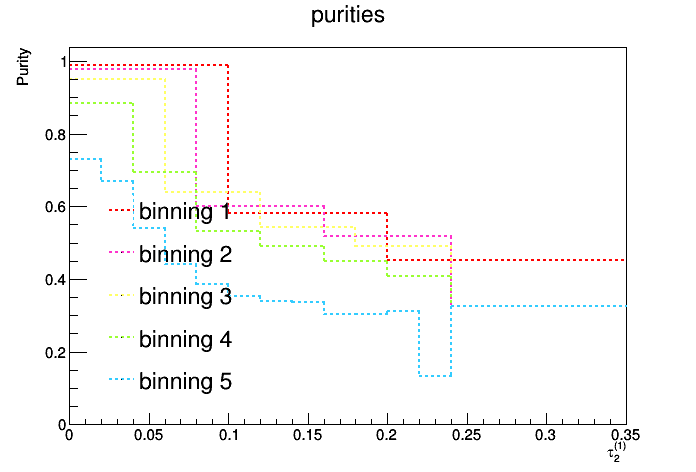

In [27]:
c=rt.TCanvas()
stack_purities.Draw("nostack")
stack_purities.GetXaxis().SetTitle("#tau_{2}^{(1)}")
stack_purities.GetYaxis().SetTitle("Purity")
stack_purities.Draw("nostack")
leg_purities.Draw("same")
c.Draw()

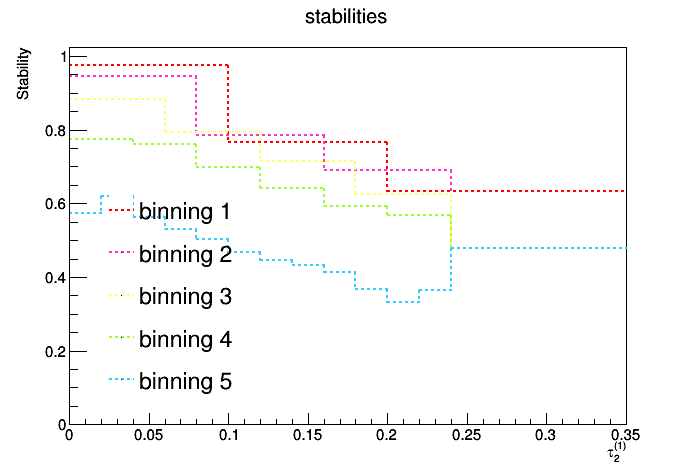

In [28]:
c=rt.TCanvas()
stack_stabilities.Draw("nostack")
stack_stabilities.GetXaxis().SetTitle("#tau_{2}^{(1)}")
stack_stabilities.GetYaxis().SetTitle("Stability")
stack_stabilities.Draw("nostack")
leg_stabilities.Draw("Same")
c.Draw()

# $\tau_2^{(2)}$

In [30]:
reco='recoJet_tau_2_2_WTA_kT_nom_dijetSel'
gen='genJet_tau_2_2_WTA_kT_dijetSel'
response='respJet_tau_2_2_WTA_kT_nom_dijetSel'

Warning in <TROOT::Append>: Replacing existing TH1: Data_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC1_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC1_gen0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC2_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC2_gen0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response2 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c0


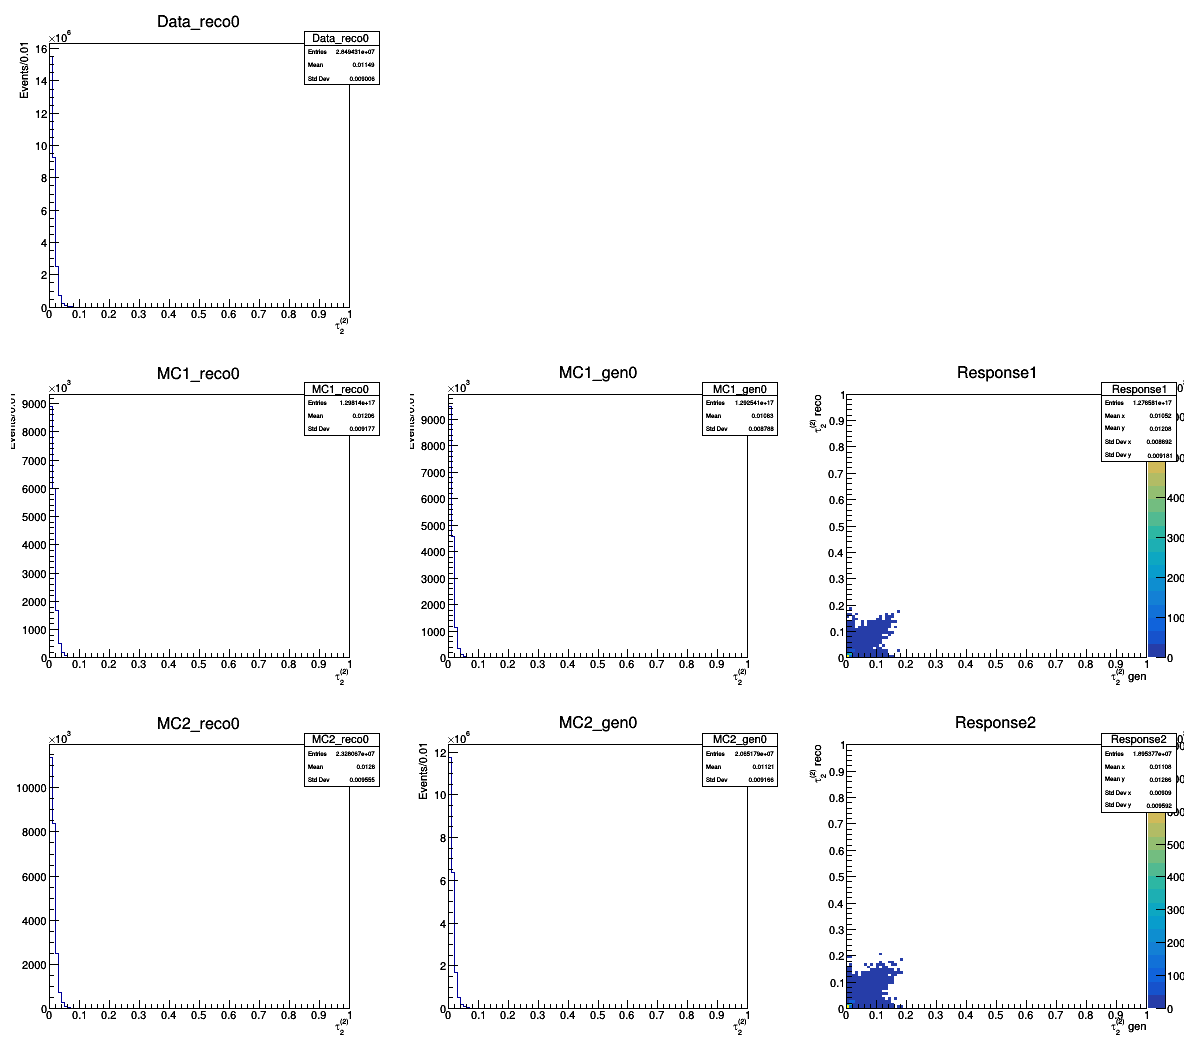

In [31]:
Data_reco0=rt.TH1D("Data_reco0","Data_reco0;#tau_{2}^{(2)};Events/0.01",100,0,1)
MC1_reco0=rt.TH1D("MC1_reco0","MC1_reco0;#tau_{2}^{(2)};Events/0.01",100,0,1)
MC1_gen0=rt.TH1D("MC1_gen0","MC1_gen0;#tau_{2}^{(2)};Events/0.01",100,0,1)
MC2_reco0=rt.TH1D("MC2_reco0","MC2_reco0;#tau_{2}^{(2)};Events/0.01",100,0,1)
MC2_gen0=rt.TH1D("MC2_gen0","MC2_gen0;#tau_{2}^{(2)};Events/0.01",100,0,1)
Response1_0=rt.TH2D("Response1","Response1;#tau_{2}^{(2)} gen;#tau_{2}^{(2)} reco",100,0,1,100,0,1)
Response2_0=rt.TH2D("Response2","Response2;#tau_{2}^{(2)} gen;#tau_{2}^{(2)} reco",100,0,1,100,0,1)

f_Data=np.zeros((len(fData),),dtype=rt.TFile)
for i in range(len(fData)):
    f_Data[i]=rt.TFile.Open(fData[i],'read')
    t=f_Data[i].Get('jetObservables')
    hist=rt.TH1D("",";;",20,0,1)
    Data_reco0.Add(t.Get(reco))
    f_Data[i].Close()

f_MC=np.zeros((len(fMC),),dtype=rt.TFile)
i=0
f_MC[i]=rt.TFile.Open(fMC[i],'read')
t=f_MC[i].Get('jetObservables')
MC1_reco0.Add(t.Get(reco),Scale[i])
MC1_gen0.Add(t.Get(gen),Scale[i])
Response1_0.Add(t.Get(response),Scale[i])
f_MC[i].Close()

for i in range(1,len(fMC)):
    f_MC[i]=rt.TFile.Open(fMC[i],'read')
    t=f_MC[i].Get('jetObservables')
    MC2_reco0.Add(t.Get(reco),Scale[i])
    MC2_gen0.Add(t.Get(gen),Scale[i])
    Response2_0.Add(t.Get(response),Scale[i])
    f_MC[i].Close()

c0=rt.TCanvas("c0","c0",0,0,1200,1080)
c0.Divide(3,3)
c0.cd(1)
Data_reco0.Draw("hist")
c0.cd(4)
MC1_reco0.Draw("hist")
c0.cd(5)
MC1_gen0.Draw("hist")
c0.cd(6)
Response1_0.Draw("Colz")
c0.cd(7)
MC2_reco0.Draw("hist")
c0.cd(8)
MC2_gen0.Draw("hist")
c0.cd(9)
Response2_0.Draw("Colz")
c0.Draw()

In [32]:
for i in range(MC2_reco0.GetNbinsX()):
    print Response2_0.ProjectionX().GetBinCenter(i+1),Response2_0.ProjectionX().GetBinContent(i+1),Response2_0.ProjectionY().GetBinContent(i+1)

0.005 10967167.8459 9186116.05598
0.015 5777864.48063 6817117.2189
0.025 1522652.39575 2046013.78382
0.035 458136.388178 609055.680132
0.045 171310.370647 213015.408255
0.055 76339.0037054 91849.6137805
0.065 35525.8421809 39535.5025501
0.075 14299.234399 16436.382737
0.085 6398.98343467 8717.17240989
0.095 4027.36845116 4187.28290933
0.105 1528.41891205 1813.93995046
0.115 530.889373349 1840.16568222
0.125 393.492187939 438.273388924
0.135 245.239071234 472.556171747
0.145 98.5016627229 34.4784098931
0.155 82.1969181968 19.1309375735
0.165 5.72540462497 12.3960974559
0.175 74.8662965647 2.3229213347
0.185 1.12420604729 0.00433960542369
0.195 0.0 2.9727311204
0.205 0.0 2.02519510138
0.215 0.0 0.0
0.225 0.0 0.0
0.235 0.0 0.0
0.245 0.0 0.0
0.255 0.0 0.0
0.265 0.0 0.0
0.275 0.0 0.0
0.285 0.0 0.0
0.295 0.0 0.0
0.305 0.0 0.0
0.315 0.0 0.0
0.325 0.0 0.0
0.335 0.0 0.0
0.345 0.0 0.0
0.355 0.0 0.0
0.365 0.0 0.0
0.375 0.0 0.0
0.385 0.0 0.0
0.395 0.0 0.0
0.405 0.0 0.0
0.415 0.0 0.0
0.425 0.0 0.0


In [33]:
gen_bins=[]
reco_bins=[]

gen_bins1=np.array([x for x in np.linspace(num=2,start=0.,stop=0.08)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.21])))
reco_bins1=np.array([x for x in np.linspace(num=3,start=0.,stop=0.08)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.14,0.21])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=3,start=0.,stop=0.12)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.21])))
reco_bins1=np.array([x for x in np.linspace(num=5,start=0.,stop=0.12)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.16,0.21])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=5,start=0.,stop=0.16)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.21])))
reco_bins1=np.array([x for x in np.linspace(num=9,start=0.,stop=0.16)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.18,0.21])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=8,start=0.,stop=0.14)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.21])))
reco_bins1=np.array([x for x in np.linspace(num=15,start=0.,stop=0.14)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.17,0.21])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

Colors=[rt.kRed,rt.kPink+9,rt.kYellow-7,rt.kSpring-9,rt.kAzure+8,rt.kBlue]

[0.   0.08 0.21] 2
[0.   0.04 0.08 0.14 0.21] 4
[0.   0.06 0.12 0.21] 3
[0.   0.03 0.06 0.09 0.12 0.16 0.21] 6
[0.   0.04 0.08 0.12 0.16 0.21] 5
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.21] 10
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.21] 8
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.17 0.21] 16


In [34]:
hist_purities=[]
hist_stabilities=[]
stack_unfoldings=[]
ratio_unfoldings=[]

responses=[]

c=rt.TCanvas()
stack_purities=rt.THStack("purities","purities")
stack_stabilities=rt.THStack("stabilities","stabilities")

leg_unfoldings=[]
leg_purities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_purities.SetLineColor(0)
leg_purities.SetBorderSize(0)
leg_purities.SetFillStyle(0)
leg_stabilities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_stabilities.SetLineColor(0)
leg_stabilities.SetBorderSize(0)
leg_stabilities.SetFillStyle(0)

for i in range(len(gen_bins)):
    gen_bin=gen_bins[i]
    reco_bin=reco_bins[i]
    print "for binning %d"%(i+1)
    print gen_bin
    
    Data_reco=rt.TH1D("Data_reco","Data_reco;#tau_{2}^{(2)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_reco=rt.TH1D("MC_reco (QCD)","MC2_reco (QCD);#tau_{2}^{(2)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_gen=rt.TH1D("MC_gen (QCD)","MC_gen (QCD);#tau_{2}^{(2)};Events",gen_bin.shape[0]-1,gen_bin)
    Response2=rt.TH2D("Response Matrix (QCD)","Response Matrix (QCD);#tau_{2}^{(2)} gen;#tau_{2}^{(2)} reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
    
    Fill1D(Data_reco0,Data_reco,reco_bin)
    Fill1D(MC2_reco0,MC2_reco,reco_bin)
    Fill1D(MC2_gen0,MC2_gen,gen_bin)
    Fill2D(Response2_0,Response2,gen_bin,reco_bin)

    Response2.SetTitle("Response Matrix #tau_{2}^{(2)} binning %d"%(i+1))
    Response2.SetStats(0)
    responses.append(Response2)
    
    purity,stability=PurityStability(Response2_0,gen_bin)
    
    purity.SetTitle("purity %d"%(i+1))
    stability.SetTitle("stability %d"%(i+1))
    purity.SetLineColor(Colors[i])
    stability.SetLineColor(Colors[i])
    hist_purities.append(purity)
    hist_stabilities.append(stability)
    stack_purities.Add(purity)
    stack_stabilities.Add(stability)
    leg_purities.AddEntry(purity,"binning %d"%(i+1))
    leg_stabilities.AddEntry(stability,"binning %d"%(i+1))
    
    Data_reco.Scale(1.0/Data_reco.Integral())
    MC2_reco.Scale(1.0/MC2_reco.Integral())
    MC2_gen.Scale(1.0/MC2_gen.Integral())
    
    hs,ratio,leg=DoUnfolding(Response2,Data_reco,MC2_reco,MC2_gen,"#tau_{2}^{(2)}","QCD",gen_bin)
    
    hs.SetTitle("#tau_{2}^{(2)} binning %d"%(i+1))
    ratio.SetTitle("Ratios binning %d"%(i+1))
    stack_unfoldings.append(hs)
    ratio_unfoldings.append(ratio)
    leg_unfoldings.append(leg)

for binning 1
[0.   0.08 0.21]
for binning 2
[0.   0.06 0.12 0.21]
for binning 3
[0.   0.04 0.08 0.12 0.16 0.21]
for binning 4
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.21]


Warning in <TROOT::Append>: Replacing existing TH1: Data_reco (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_reco (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_gen (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response Matrix (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Purity (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Stability (Potential memory leak).
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 4 input bins and 2 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{2}^{(2)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #3 (xaxis:#tau_{2}^{(2)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densit

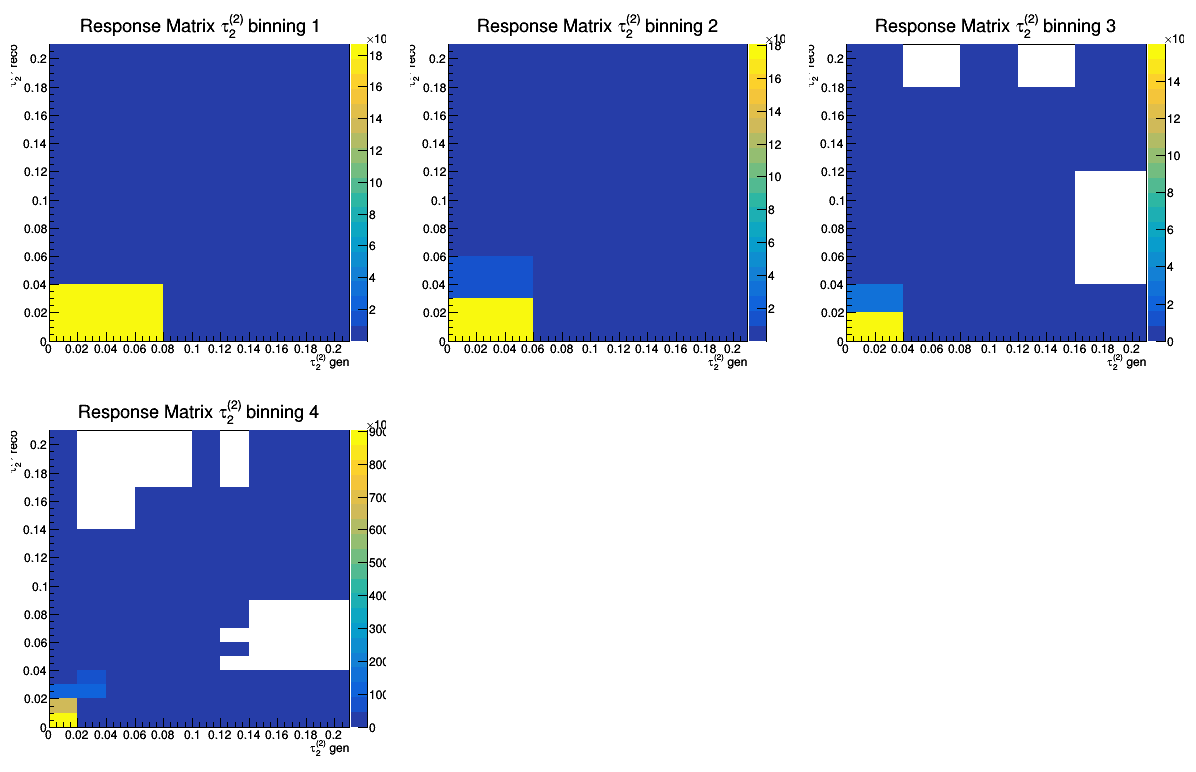

In [35]:
c=rt.TCanvas("","",0,0,1200,800)
c.Divide(3,2)
for i in range(len(gen_bins)):
    c.cd(i+1)
    responses[i].Draw("Colz")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


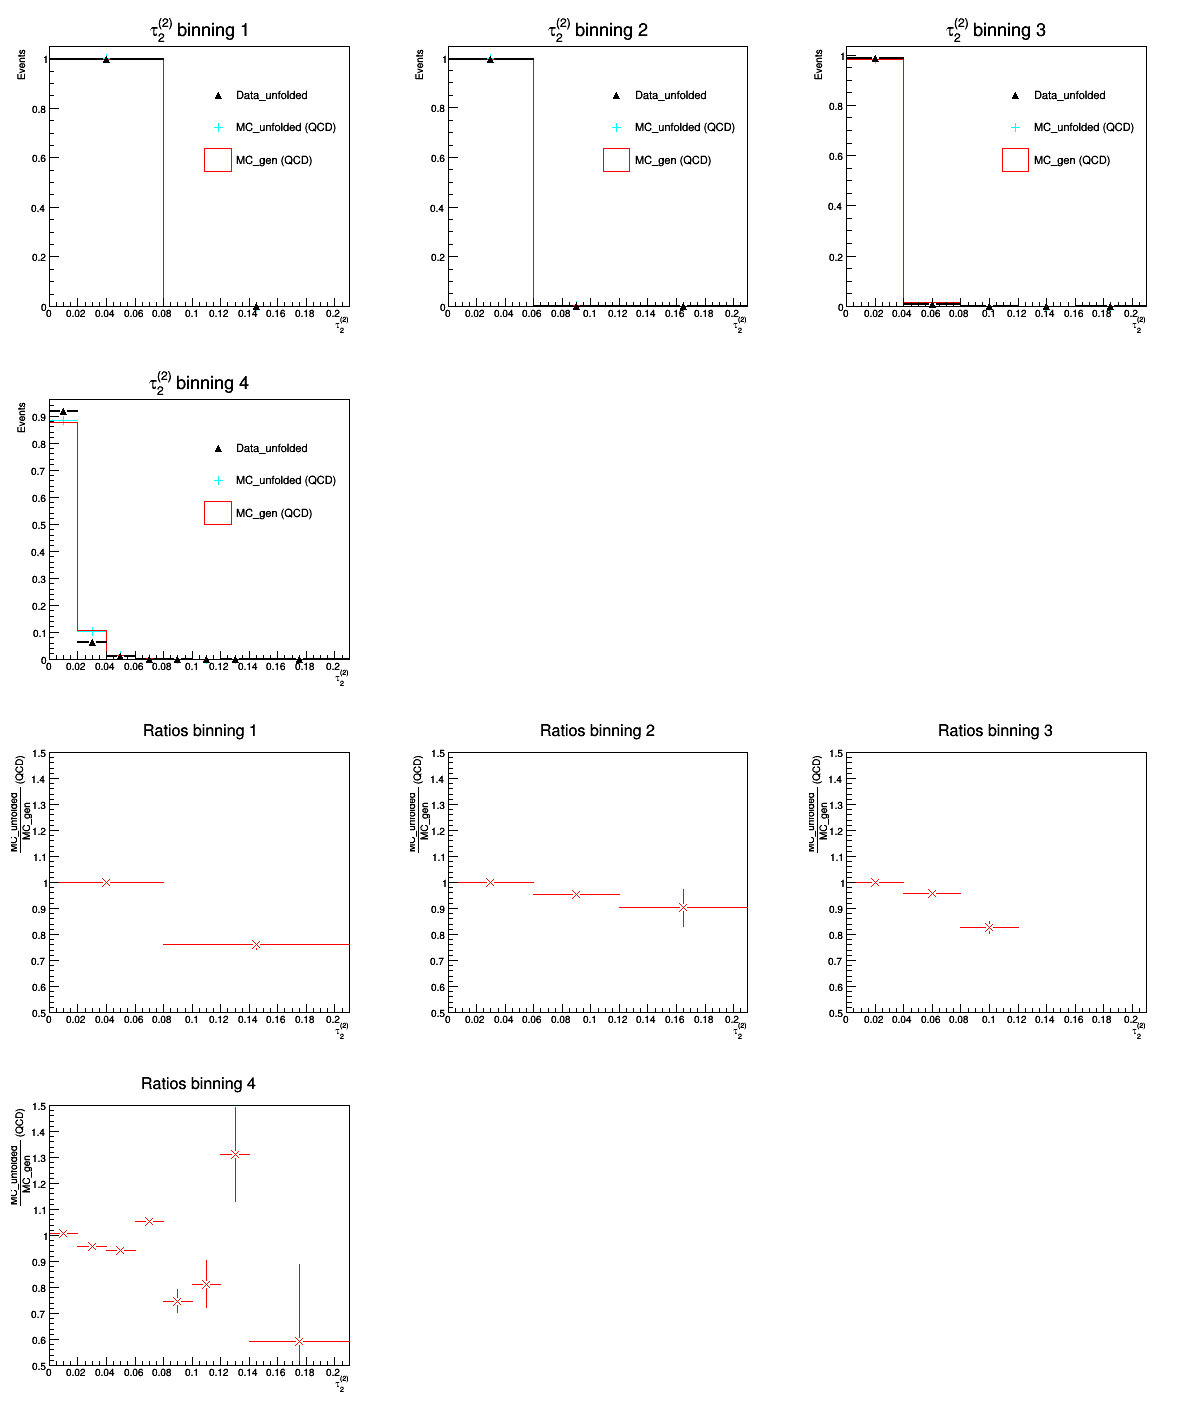

In [36]:
c=rt.TCanvas("","",0,0,1200,1440)
c.Divide(3,4)
for i in range(len(gen_bins)):
    c.cd(i+1)
    stack_unfoldings[i].Draw("nostack")
    stack_unfoldings[i].GetXaxis().SetTitle("#tau_{2}^{(2)}")
    stack_unfoldings[i].GetYaxis().SetTitle("Events")
    leg_unfoldings[i].Draw("Same")
for i in range(6,6+len(gen_bins)):
    c.cd(i+1)
    ratio_unfoldings[i-6].Draw()
c.Draw()

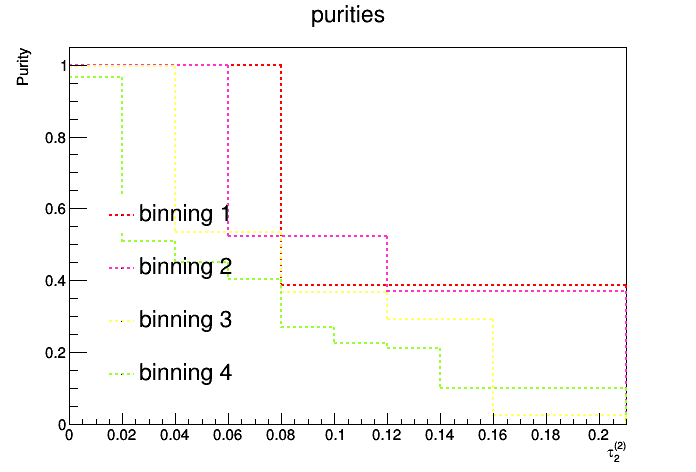

In [37]:
c=rt.TCanvas()
stack_purities.Draw("nostack")
stack_purities.GetXaxis().SetTitle("#tau_{2}^{(2)}")
stack_purities.GetYaxis().SetTitle("Purity")
stack_purities.Draw("nostack")
leg_purities.Draw("same")
c.Draw()

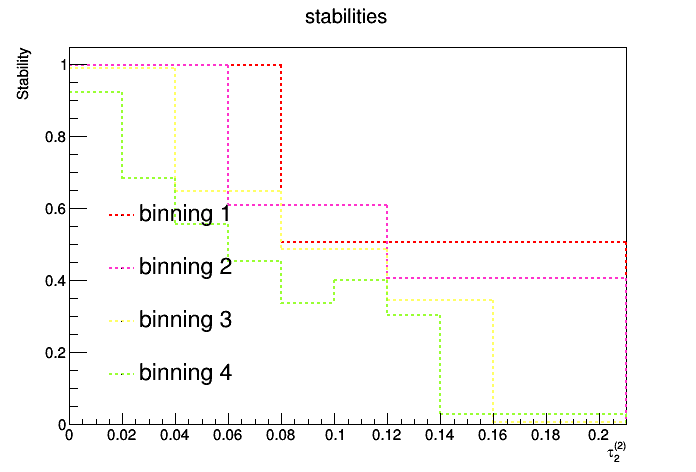

In [38]:
c=rt.TCanvas()
stack_stabilities.Draw("nostack")
stack_stabilities.GetXaxis().SetTitle("#tau_{2}^{(2)}")
stack_stabilities.GetYaxis().SetTitle("Stability")
stack_stabilities.Draw("nostack")
leg_stabilities.Draw("Same")
c.Draw()